# Environment
* virtual env: source envs/pSEOBNRv4HM_tgr_injections/bin/activate
* lalsuite: source $VIRTUAL_ENV/opt/lalsuite_pSEOBNRv4HM_tgr_injection/etc/lal*.sh

In [30]:
#%matplotlib notebook
import os
import matplotlib.pyplot as plt
import numpy as np
import lal
import lalsimulation as lalsim
import sys
sys.path.append('../scripts')
import compute_sigmalm0_SimIMREOBGenerateQNMFreqV2 as calcqnm
import scipy
import scipy.signal as ss
from scipy import interpolate
import scipy.ndimage.filters as filter
from optparse import OptionParser
import corner
import glob
import h5py
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import rc
matplotlib.rc('text.latex', preamble = r'\usepackage{txfonts}')
rc_params = {'backend': 'ps',
             'axes.labelsize': 10,
             'axes.titlesize': 10,
             'font.size': 12,
             'legend.fontsize': 8,
             'xtick.labelsize': 13,
             'ytick.labelsize': 13,
             'font.family': 'Times New Roman'
             }

plt.rcParams.update(rc_params)

### Functions

In [23]:
# Module for confidence calculations
class confidence(object):
    def __init__(self, counts):
        # Sort in descending order in frequency
        self.counts_sorted = np.sort(counts.flatten())[::-1]
        # Get a normalized cumulative distribution from the mode
        self.norm_cumsum_counts_sorted = np.cumsum(self.counts_sorted) / np.sum(counts)
        # Set interpolations between heights, bins and levels
        self._set_interp()
    def _set_interp(self):
        self._length = len(self.counts_sorted)
        # height from index
        self._height_from_idx = interpolate.interp1d(np.arange(self._length), self.counts_sorted, bounds_error=False, fill_value=0.)
        # index from height
        self._idx_from_height = interpolate.interp1d(self.counts_sorted[::-1], np.arange(self._length)[::-1], bounds_error=False, fill_value=self._length)
        # level from index
        self._level_from_idx = interpolate.interp1d(np.arange(self._length), self.norm_cumsum_counts_sorted, bounds_error=False, fill_value=1.)
        # index from level
        self._idx_from_level = interpolate.interp1d(self.norm_cumsum_counts_sorted, np.arange(self._length), bounds_error=False, fill_value=self._length)
    def level_from_height(self, height):
        return self._level_from_idx(self._idx_from_height(height))
    def height_from_level(self, level):
        return self._height_from_idx(self._idx_from_level(level))

# gaussian filter of histogram
def gf(P):
    return filter.gaussian_filter(P, sigma=2.0)

# construct effective quantities from PE samples
def eff_quant(m1, m2, a1z, a2z, domega, dtau, lm):
    omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
    freq_GR = omega_GR/(2.*np.pi)

    omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
    freq_modGR = omega_modGR/(2.*np.pi)
    
    return freq_GR, tau_GR, freq_modGR, tau_modGR

# using fitting formulas from https://arxiv.org/pdf/gr-qc/0512160.pdf
# to get final mass and final spin from omega220 and tau220.
# See eqs.2.1, E1 and E2, and table VIII for fitting coefficients

def Mjfinal220(omega220,tau220):

    jf=1-pow((omega220*tau220/2.-0.7)/(1.4187),-1/0.4990)
    Mf=((1.5251 - 1.1568*pow((1 - jf),0.1292))/omega220)*(pow(lal.C_SI,3)/lal.G_SI/lal.MSUN_SI)

    return Mf,jf

# 2D histogram
def P_xy_2dhist(x, y, N_bins):
    x_bins = np.linspace(min(x), max(x), N_bins)
    y_bins = np.linspace(min(y), max(y), N_bins)

    dx = np.mean(np.diff(x_bins))
    dy = np.mean(np.diff(y_bins))

    x_intp = (x_bins[:-1] + x_bins[1:])/2.
    y_intp = (y_bins[:-1] + y_bins[1:])/2.
    
    P_xy, x_bins, y_bins = np.histogram2d(x, y, bins=(x_bins, y_bins), normed=True)
    P_xy = P_xy.T
    
    conf = confidence(P_xy)
    s1 = conf.height_from_level(0.5)
    s2 = conf.height_from_level(0.9)
    
    P_x = np.sum(P_xy, axis=0) * dy
    P_y = np.sum(P_xy, axis=1) * dx
    
    return P_xy, P_x, P_y, x_intp, y_intp, s1, s2

# Software Injections: GR/nonGR

In [24]:
# data

event_list = ['GW150914', 'GW190521']
run_list = ['0p0', '0p5', '0p0_GR', '0p5_GR']

data_dict = {}

for event in event_list:
    data_dict[event] = {}
    
    for run in run_list:
        
        data_loc = glob.glob('../runs/nonGR/%s-like/*_%s_widerdist/cbcBayes/posterior_samples.dat'%(event, run))[0]
        data_dict[event][run] = np.genfromtxt(data_loc, dtype=None, names=True)

{'GW150914': {'0p0': array([(1., 2074.35120026,  0., 0.37538044, 1.12628522e+09, 20., 0., -0.05579533, 15.14766731, 72.24031261, 68.77874889, 120.34606445, 1., 1.14718761,  -6.2848744 , -306.80692691, 4096., -0.03625697, 27.65386468, 1., 1., 300.52205251, 3.66821432, 18.99582412, -0.01569986, 22.82378887, 0.00411582, 1.12628521e+09, 38.03458465, 5.08988347, 1.12628522e+09, 34.20572796, 50.00707203, 8., 0.01981568, 24.87001188, 0.01569986, 2.12482168, 2.51680453, -0.00628429, 180.17598806, 0.68050455,  0.96446063,  0.17142869, 1.12628522e+09, 4., 0.68050455, 0.15728205, 0.17142869, 2., 8., 24.18989608, 2.47496828, -0.08162432, -0.15728205,    6000., 0.26740192, 5.36999279e+08, -0.00411582, 31.39139285, 15.52165414, -0.01981568, 26.53875643, 327.06080894, 20.,  0.01953835, 1.12628522e+09, -0.00163779, 0.89933223, 52.52387656, 1.12628522e+09, 0.24929771, 94., 18.85999064, 0.21665605, 0., -0.77398522, 24.51840168),
       (1., 2062.06718167,  0., 0.37348399, 1.12628522e+09, 20., 0., -0.110

## GW150914

[246.80589509] [4.13815066] [370.20884264] [6.20722599]


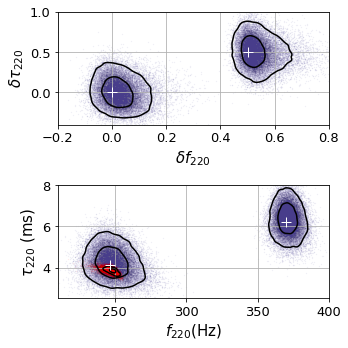

In [47]:
m1_inj, m2_inj, a1z_inj, a2z_inj = 38.528614, 33.400536, 0.003469902, -0.04400404
freq_GR_inj, tau_GR_inj, freq_modGR_inj, tau_modGR_inj = eff_quant(np.array([m1_inj]), \
                                                                   np.array([m2_inj]), \
                                                                   np.array([a1z_inj]), \
                                                                   np.array([a2z_inj]), \
                                                                   0.5, 0.5, [2,2])
tau_GR_inj *= 1000.
tau_modGR_inj *= 1000.
print(freq_GR_inj, tau_GR_inj, freq_modGR_inj, tau_modGR_inj)

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for run in ['0p0', '0p5']:

    # read data
    data = data_dict['GW150914'][run]

    # read out the specific columns: m1,m2,a1z,a2z,domega220,dtau220
    m1, m2, a1z, a2z, domega, dtau = data["m1"], data["m2"], data["a1z"], data["a2z"], data["domega220"], data["dtau220"]
    
    # construct the frequencies and damping times
    freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])

    # converty damping time samples from second to milli-second
    tau_GR *= 1000.
    tau_modGR *= 1000.
    
    # construct 2D histogram in domega220,dtau220
    P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(domega, dtau, N_bins=100)
    dx = np.mean(np.diff(x_intp))
    dy = np.mean(np.diff(y_intp))
    P_xy /= np.sum(P_xy) * dx * dy # normalise histogram
    
    #ax1.pcolormesh(x_intp, y_intp, gf(P_xy), cmap='Purples')
    ax1.scatter(domega, dtau, color='darkslateblue', alpha=0.1, s=0.1)
    ax1.contour(x_intp, y_intp, gf(P_xy), levels=(s2,s1), colors='k')
    
    # construct 2D histogram in omega220,tau220
    P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(freq_modGR, tau_modGR, N_bins=100)
    dx = np.mean(np.diff(x_intp))
    dy = np.mean(np.diff(y_intp))
    P_xy /= np.sum(P_xy) * dx * dy # normalise histogram

    #ax2.pcolormesh(x_intp, y_intp, gf(P_xy), cmap='Purples')
    ax2.scatter(freq_modGR, tau_modGR, color='darkslateblue', alpha=0.1, s=0.1)
    ax2.contour(x_intp, y_intp, gf(P_xy), levels=(s2,s1), colors='k')

# nGR: SEOBN$v4HM
data = data_dict['GW150914']['0p5_GR']

m1, m2, a1z, a2z = data["m1"], data["m2"], data["a1z"], data["a2z"]
domega, dtau = np.zeros(len(m1)), np.zeros(len(m1))
freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])

tau_GR *= 1000.
tau_modGR *= 1000.

# construct 2D histogram in omega220GR,tau220GR
P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(freq_modGR, tau_modGR, N_bins=100)
dx = np.mean(np.diff(x_intp))
dy = np.mean(np.diff(y_intp))
P_xy /= np.sum(P_xy) * dx * dy # normalise histogram

#ax4.pcolormesh(x_intp, y_intp, gf(P_xy), cmap='Greys')
ax2.scatter(freq_modGR, tau_modGR, color='r', alpha=0.1, s=0.1)
ax2.contour(x_intp, y_intp, gf(P_xy), levels=(s2,s1), colors='k')

# plot GR predictions
ax1.plot(0,0,color='w',marker='+', ms=10)
ax1.plot(0.5,0.5,color='w',marker='+', ms=10)

ax2.plot(freq_GR_inj, tau_GR_inj,color='w',marker='+', ms=10)
ax2.plot(freq_modGR_inj, tau_modGR_inj,color='w',marker='+', ms=10)

ax1.set_xlabel("$\delta f_{220}$", size=15)
ax1.set_ylabel(r"$\delta \tau_{220}$", size=15)
ax2.set_xlabel("$f_{220}$(Hz)", size=15)
ax2.set_ylabel(r"$\tau_{220}$ (ms)", size=15) 

ax1.set_xlim([-0.2,0.8])
ax1.set_ylim([-0.4,1.])

ax2.set_xlim([210,400])
ax2.set_ylim([2.5,8])

ax1.grid()
ax2.grid()

plt.tight_layout()
plt.savefig('../papers/intro_paper/figures/GW150914_simulated_signal_gr_ngr.png', dpi=300)

## GW190521

[65.42878048] [15.74851893] [98.14317072] [23.6227784]


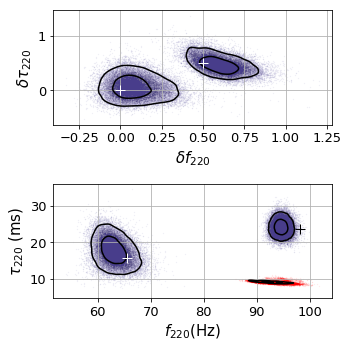

In [49]:
m1_inj, m2_inj, a1z_inj, a2z_inj = 152.599213, 120.400780, 0.02299293, 0.02299293
freq_GR_inj, tau_GR_inj, freq_modGR_inj, tau_modGR_inj = eff_quant(np.array([m1_inj]), \
                                                                   np.array([m2_inj]), \
                                                                   np.array([a1z_inj]), \
                                                                   np.array([a2z_inj]), \
                                                                   0.5, 0.5, [2,2])
tau_GR_inj *= 1000.
tau_modGR_inj *= 1000.
print(freq_GR_inj, tau_GR_inj, freq_modGR_inj, tau_modGR_inj)

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for run in ['0p0', '0p5']:

    # read data
    data = data_dict['GW190521'][run]

    # read out the specific columns: m1,m2,a1z,a2z,domega220,dtau220
    m1, m2, a1z, a2z, domega, dtau = data["m1"], data["m2"], data["a1z"], data["a2z"], data["domega220"], data["dtau220"]
    
    # construct the frequencies and damping times
    freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])

    # converty damping time samples from second to milli-second
    tau_GR *= 1000.
    tau_modGR *= 1000.
    
    # construct 2D histogram in domega220,dtau220
    P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(domega, dtau, N_bins=100)
    dx = np.mean(np.diff(x_intp))
    dy = np.mean(np.diff(y_intp))
    P_xy /= np.sum(P_xy) * dx * dy # normalise histogram
    
    #ax1.pcolormesh(x_intp, y_intp, gf(P_xy), cmap='Purples')
    ax1.scatter(domega, dtau, color='darkslateblue', alpha=0.1, s=0.1)
    ax1.contour(x_intp, y_intp, gf(P_xy), levels=(s2,s1), colors='k')
    
    # construct 2D histogram in omega220,tau220
    P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(freq_modGR, tau_modGR, N_bins=100)
    dx = np.mean(np.diff(x_intp))
    dy = np.mean(np.diff(y_intp))
    P_xy /= np.sum(P_xy) * dx * dy # normalise histogram

    #ax2.pcolormesh(x_intp, y_intp, gf(P_xy), cmap='Purples')
    ax2.scatter(freq_modGR, tau_modGR, color='darkslateblue', alpha=0.1, s=0.1)
    ax2.contour(x_intp, y_intp, gf(P_xy), levels=(s2,s1), colors='k')

# nGR: SEOBN$v4HM
data = data_dict['GW190521']['0p5_GR']

m1, m2, a1z, a2z = data["m1"], data["m2"], data["a1z"], data["a2z"]
domega, dtau = np.zeros(len(m1)), np.zeros(len(m1))
freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])

tau_GR *= 1000.
tau_modGR *= 1000.

# construct 2D histogram in omega220GR,tau220GR
P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(freq_modGR, tau_modGR, N_bins=100)
dx = np.mean(np.diff(x_intp))
dy = np.mean(np.diff(y_intp))
P_xy /= np.sum(P_xy) * dx * dy # normalise histogram

#ax4.pcolormesh(x_intp, y_intp, gf(P_xy), cmap='Greys')
ax2.scatter(freq_modGR, tau_modGR, color='r', alpha=0.1, s=0.1)
ax2.contour(x_intp, y_intp, gf(P_xy), levels=(s2,s1), colors='k')

# plot GR predictions
ax1.plot(0,0,color='w',marker='+', ms=10)
ax1.plot(0.5,0.5,color='w',marker='+', ms=10)

ax2.plot(freq_GR_inj, tau_GR_inj,color='w',marker='+', ms=10)
ax2.plot(freq_modGR_inj, tau_modGR_inj,color='k',marker='+', ms=10)

ax1.set_xlabel("$\delta f_{220}$", size=10)
ax1.set_ylabel(r"$\delta \tau_{220}$", size=10)
ax2.set_xlabel("$f_{220}$(Hz)", size=10)
ax2.set_ylabel(r"$\tau_{220}$ (ms)", size=10) 

#ax1.set_xlim([-0.2,0.8])
#ax1.set_ylim([-0.4,1.])

#ax2.set_xlim([210,400])
#ax2.set_ylim([2.5,8])

ax1.grid()
ax2.grid()

plt.tight_layout()
plt.savefig('../papers/intro_paper/figures/GW190521_simulated_signal_gr_ngr.png', dpi=300)

## No-hair test with SXS:BBH:0166

In [ ]:
data_220 = '../runs/parallel_bilby/GW150914_SXS_BBH_0166/outdir/'

## O1-O2 events

GW150914
GW170104
GW170729


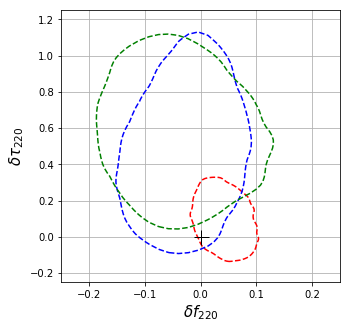

In [105]:
import json

event_list = ["GW150914", "GW170104", "GW170729"]#, "GW170814", "GW170823"]
color_list = ["r", "b", "g"]

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)

for (color,event) in zip(color_list,event_list):
    
    print(event)

    postloc_nongr = "../runs/parallel_bilby/%s_pSEOBNRv4HM/outdir/%s_result.json"%(event, event)
    
    with open(postloc_nongr, "r") as f:
        data = json.load(f)
   

    m1, m2, domega, dtau = data['posterior']['content']["mass_1"], \
    data['posterior']['content']["mass_2"], \
    data['posterior']['content']["domega220"], \
    data['posterior']['content']["dtau220"]
    
    m1, m2, domega, dtau = np.array(m1), np.array(m2), np.array(domega), np.array(dtau)
    a1z, a2z = np.zeros(len(m1)), np.zeros(len(m1))
    
    freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])
    mf_modGR, af_modGR = Mjfinal220(freq_modGR*2*np.pi,tau_modGR)
 
    P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(domega, dtau, N_bins=100)

    ax1.contour(x_intp, y_intp, gf(P_xy), levels=(s2,), colors=color, linestyles=ls)
    ax1.grid(True)
    

ax1.set_xlabel("$\delta f_{220}$", fontsize=15)
ax1.set_ylabel("$\delta \\tau_{220}$", fontsize=15)
ax1.plot(0,0,'k+',ms=15)
ax1.set_xlim([-0.25,0.25])
ax1.set_ylim([-0.25,1.25])
plt.savefig('../papers/intro_paper/figures/O1O2_realevents.png', dpi=300)

# Noise Systematics

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0, 0.5, '$\\tau$ (ms)')

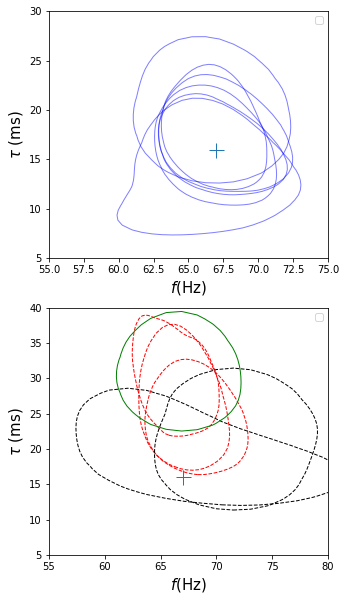

In [109]:
fig = plt.figure(figsize=(5,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

## Gaussian Noise

postloc = '../runs/parallel_bilby'
noise_list = ["noise01", "noise02", "noise03", "noise04", "noise05", "zeronoise"]

for (idx, noise) in enumerate(noise_list):
    f, tau = np.genfromtxt(postloc + '/S190521g_NRSurEXP30inj_pSEOBNRv4HM_%s/pesummary/samples/qnmtest/qnmtest_abs_params_f_tau_modGR_data.dat'%noise, unpack=True)
    P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(f, tau*1000, 50)
    ax1.contour(x_intp,y_intp,gf(P_xy), levels=(s2,), linewidths=(1,1.5), colors='b', alpha=0.5)

ax1.legend(loc="best")
ax1.plot(67, 16, "+", ms=15)    
ax1.set_xlim([55,75])
ax1.set_ylim([5, 30])
ax1.set_xlabel("$f$(Hz)", size=15)
ax1.set_ylabel(r"$\tau$ (ms)", size=15)    

## Real Noise

postloc = '../runs/review/21g_injections/NRSur7dq4_MaxL_EXP30_realnoise'
gpstime_list = ["1242461657", "1242463457", "1242456257", "1242458057", "1242454457"]

for gpstime in gpstime_list:
    f, tau = np.genfromtxt(postloc + "/%s/cbcBayes/qnmtest/qnmtest_abs_params_f_tau_modGR_data.dat"%gpstime, unpack=True)
    P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(f, tau*1000, 50)
    if gpstime == "1242458057" or gpstime == "1242454457":
        ax2.contour(x_intp,y_intp,gf(P_xy), levels=(s2,), linewidths=(1,1.5), colors='k', linestyles=("dashed",))
    else: 
        ax2.contour(x_intp,y_intp,gf(P_xy), levels=(s2,), linewidths=(1,1.5), colors='r', linestyles=("dashed",))

# Actual Event        
  
postloc = '../runs/O3a/GW190521a/220_rererun_newpsd'    
f, tau = np.genfromtxt(postloc + "/cbcBayes/qnmtest/qnmtest_abs_params_f_tau_modGR_data.dat", unpack=True)
P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(f, tau*1000, 50)
ax2.contour(x_intp,y_intp,gf(P_xy), levels=(s2,), linewidths=(1,1.5), colors='g', linestyles=("solid",))
        

ax2.legend(loc="best")
ax2.plot(67, 16, "+", ms=15)    
ax2.set_xlim([55,80])
ax2.set_ylim([5, 40])
ax2.set_xlabel("$f$(Hz)", size=15)
ax2.set_ylabel(r"$\tau$ (ms)", size=15)

### SXS:BBH:0166

#### 220/330

No handles with labels found to put in legend.


Text(0, 0.5, '$\\tau$ (ms)')

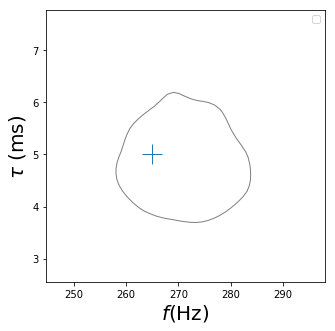

In [8]:
postloc = '../runs/parallel_bilby/GW150914_SXS_BBH_0166_330/pesummary/samples/1594069675_GW150914_checkpoint_preresult_pesummary.dat'
data = np.genfromtxt(postloc, names=True, dtype=None)

m1, m2, a1z, a2z, domega, dtau = data["mass_1"], data["mass_2"], data["chi_1"], data["chi_2"], data["domega330"], data["dtau330"]

# create (omega, tau)_GR and modGRarrays
omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, [3,3])
freq_GR = omega_GR/(2.*np.pi)

omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
freq_modGR = omega_modGR/(2.*np.pi)


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(freq_modGR, tau_modGR*1000, 50)
ax.contour(x_intp,y_intp,gf(P_xy), levels=(s2,), linewidths=(1,1.5), colors='k', alpha=0.5)


ax.legend(loc="best")
ax.plot(265, 5, "+", ms=20)    
#plt.xlim([55,75])
#plt.ylim([5, 30])
plt.xlabel("$f$(Hz)", size=20)
plt.ylabel(r"$\tau$ (ms)", size=20)